In [1]:
#import libraries
import os
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Input, concatenate, Flatten, Dense, Attention, Multiply, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Data preparation
dataset_dir= r'D:\桌面\B_test'
input_shape=(224, 224, 3)
batch_size=4

In [3]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [4]:
test_datagen=ImageDataGenerator(
    rescale=1./255)

In [15]:
# #Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation')

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary' 
)

Found 2930 images belonging to 2 classes.
Found 732 images belonging to 2 classes.
Found 3662 images belonging to 2 classes.


In [6]:
#Ensemble Model using pre-trained model

# Load pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pre-trained models
for layer in resnet_model.layers:
    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

In [7]:
# 假设 resnet_model 和 vgg_model 是你的预训练模型

input_layer = Input(shape=(224, 224, 3))
resnet_features = resnet_model(input_layer)
vgg_features = vgg_model(input_layer)

merged = concatenate([resnet_features, vgg_features])
flatten = Flatten()(merged)
dense1 = Dense(512, activation='relu')(flatten)
output_layer = Dense(1, activation='sigmoid')(dense1)

ensemble_model = Model(inputs=input_layer, outputs=output_layer)


ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_3[0][0]']                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_3[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 7, 7, 2560)   0           ['resnet50[0][0]',           

In [8]:
# Compile and train the ensemble model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
#Train the model
history=ensemble_model.fit(train_generator, batch_size=batch_size, epochs=5, validation_data=(validation_generator), verbose=1)

Epoch 1/5
733/733 [==============================] - 101s 121ms/step - loss: 0.6521 - accuracy: 0.8451 - val_loss: 0.2218 - val_accuracy: 0.9194
Epoch 2/5
733/733 [==============================] - 85s 117ms/step - loss: 0.2937 - accuracy: 0.8945 - val_loss: 0.1881 - val_accuracy: 0.9262
Epoch 3/5
733/733 [==============================] - 86s 117ms/step - loss: 0.2562 - accuracy: 0.9082 - val_loss: 0.1987 - val_accuracy: 0.9303
Epoch 4/5
733/733 [==============================] - 86s 117ms/step - loss: 0.2473 - accuracy: 0.9130 - val_loss: 0.2169 - val_accuracy: 0.9153
Epoch 5/5
733/733 [==============================] - 86s 117ms/step - loss: 0.2338 - accuracy: 0.9143 - val_loss: 0.1894 - val_accuracy: 0.9208


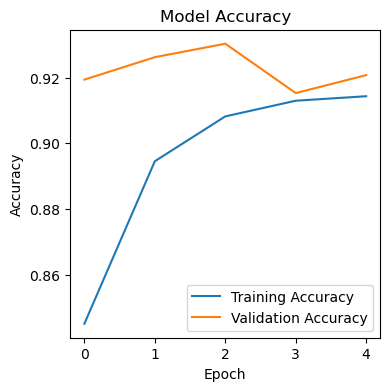

In [10]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

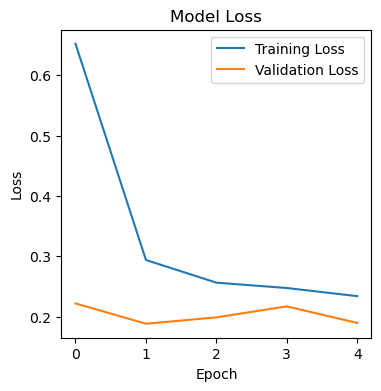

In [11]:
#Trainig loss and validation loss graph
plt.figure(figsize=(4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [12]:
# Evaluate the model on the testing dataset
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

916/916 [==============================] - 72s 79ms/step - loss: 0.3001 - accuracy: 0.9036
Test loss: 0.3001324236392975
Test accuracy: 0.9036045670509338


In [16]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

# Generate predictions for the test dataset
y_pred = ensemble_model.predict(test_generator)

916/916 [==============================] - 71s 78ms/step


In [17]:
print(y_pred)
print(test_generator.classes)

[[0.09607057]
 [0.12516433]
 [0.19554397]
 ...
 [0.9551236 ]
 [0.9762598 ]
 [0.9640768 ]]
[0 0 0 ... 1 1 1]


Binary Predictions:
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
Confusion Matrix:
[[1600  257]
 [  37 1768]]


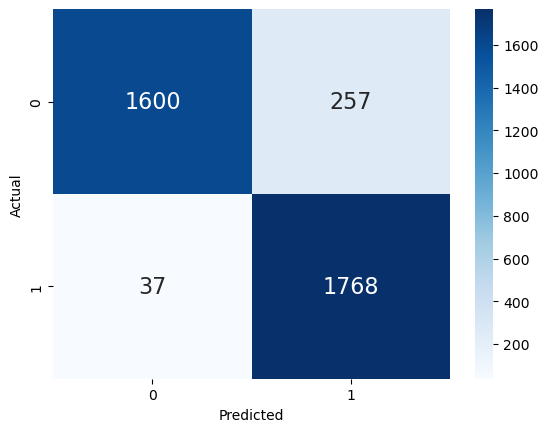

In [18]:
import numpy as np

# 使用阈值0.5将概率值转换为二分类预测结果
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)

# 打印转换后的二分类预测结果
print("Binary Predictions:")
print(y_pred_binary)

# 计算混淆矩阵
cm = confusion_matrix(test_generator.classes, y_pred_binary)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 使用Seaborn绘制热力图
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
# 获取一个批次的训练数据和标签
x_train_batch, y_train_batch = next(train_generator)

# 获取一个批次的验证数据和标签
x_val_batch, y_val_batch = next(validation_generator)

# 获取一个批次的测试数据和标签
x_test_batch, y_test_batch = next(test_generator)

# 打印训练数据和标签
print("Training Data Shape:", x_train_batch.shape)
print("Training Labels:", y_train_batch)

# 打印验证数据和标签
print("Validation Data Shape:", x_val_batch.shape)
print("Validation Labels:", y_val_batch)

# 打印测试数据和标签
print("Test Data Shape:", x_test_batch.shape)
print("Test Labels:", y_test_batch)


Training Data Shape: (4, 224, 224, 3)
Training Labels: [0. 0. 0. 1.]
Validation Data Shape: (4, 224, 224, 3)
Validation Labels: [0. 0. 0. 0.]
Test Data Shape: (4, 224, 224, 3)
Test Labels: [0. 0. 0. 0.]


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 使用阈值0.5将概率值转换为二分类预测结果
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# 获取真实标签
y_true = test_generator.classes

# 计算精确度、召回率和F1得分
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8730864197530864
Recall: 0.9795013850415513
F1 Score: 0.9232375979112272


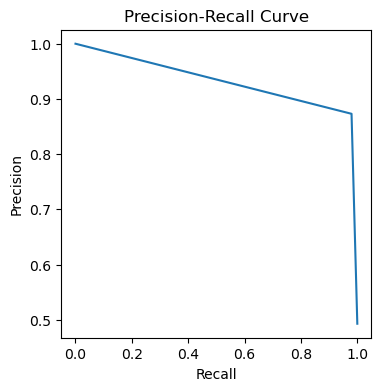

In [23]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_binary)

#plot the precision-recall curve
plt.figure(figsize=(4,4))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [24]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_binary)

#compute the AUC score
roc_auc= auc(fpr, tpr)

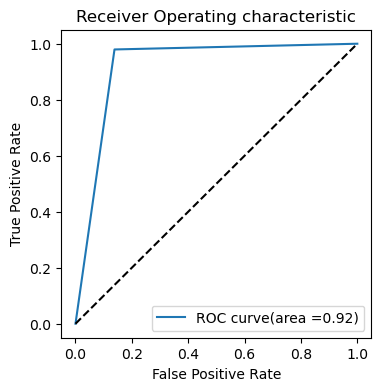

In [25]:
#plot the precision-recall curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [24]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 0.9989229940764675


In [21]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model

In [22]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()